# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [2]:
# levantamos los datos
df = pd.read_csv('podcast_dataset.csv')

# peek
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


# Preprocessing

Ver notebook de EDA.

In [3]:
# drop duplicates
df.drop_duplicates(inplace=True)

# target relativo
df['fraction_listened'] = df['Listening_Time_minutes'] / df['Episode_Length_minutes']

# encoding de episode number
df['Episode_Number'] = df['Episode_Title'].apply(lambda x: x.split(" ")[-1]).astype(int)

# ausencia de guest
df['no_guest'] = df['Guest_Popularity_percentage'].isna()

# imputacion de NaNs
df.fillna({'Guest_Popularity_percentage':-1}, inplace=True)

# dropeo de NaNs de las otras columnas y reseteo de index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# encoding de sentiment
df['sentiment_encoded'] = df['Episode_Sentiment'].map({'Neutral':0, 'Negative':-1, 'Positive':1}).astype(int)

# drop de variables ahora redundantes
df.drop(columns=['Episode_Title', 'Episode_Sentiment'], inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40374 entries, 0 to 40373
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 40374 non-null  object 
 1   Episode_Length_minutes       40374 non-null  float64
 2   Genre                        40374 non-null  object 
 3   Host_Popularity_percentage   40374 non-null  float64
 4   Publication_Day              40374 non-null  object 
 5   Publication_Time             40374 non-null  object 
 6   Guest_Popularity_percentage  40374 non-null  float64
 7   Number_of_Ads                40374 non-null  int64  
 8   Listening_Time_minutes       40374 non-null  float64
 9   fraction_listened            40374 non-null  float64
 10  Episode_Number               40374 non-null  int64  
 11  no_guest                     40374 non-null  bool   
 12  sentiment_encoded            40374 non-null  int64  
dtypes: bool(1), floa

# Baseline

Para este problema elegimos minimizar el MSE/RMSE, aunque también miramos el MAE.

In [5]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
#from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from tqdm.notebook import tqdm

In [6]:
X = df.drop(columns=['Listening_Time_minutes','fraction_listened'])
y_abs = df['Listening_Time_minutes']
y_rel = df['fraction_listened']

In [7]:
numeric_cols = X.columns[X.dtypes!='object'].tolist()
numeric_cols

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Number',
 'no_guest',
 'sentiment_encoded']

In [8]:
cat_cols = X.columns[X.dtypes=='object'].tolist()
cat_cols

['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time']

In [10]:
# utils
def rel_to_abs(y_pred_rel, X):
    return y_pred_rel * X['Episode_Length_minutes']

METRICS = {
    'mae': mean_absolute_error,
    'mse': mean_squared_error,
    'rmse': root_mean_squared_error,
}

SPLITTER = KFold(n_splits=5, random_state=42, shuffle=True)

def cv_model(model_constructor_f, X, is_rel, model_args={}):
    results = []
    models = []
    for i, (train_idx, test_idx) in tqdm(enumerate(SPLITTER.split(X)), 
                                         total=SPLITTER.get_n_splits()):
        X_train = X.loc[train_idx]
        X_test = X.loc[test_idx]

        y_train = y_rel[train_idx] if is_rel else y_abs[train_idx]
        y_test = y_abs[test_idx]

        # inst+fit model
        model = model_constructor_f(**model_args)

        model.fit(X_train, y_train)

        # predict
        y_pred = model.predict(X_test)

        # if rel, adjust to abs
        if is_rel:
            y_pred = rel_to_abs(y_pred, X_test)

        results.append({name:f(y_test, y_pred) for name,f in METRICS.items()})
        models.append(model)

    res_df = pd.DataFrame(results)
    # add mean and std values across folds for all metrics
    return pd.concat((res_df, res_df.describe().loc[['mean','std']])), models

In [11]:
# gráfico de importancias across-folds
# utils
def lr_weights(
        models: Pipeline | LinearRegression | list[Pipeline] | list[LinearRegression],
        feature_names: list[str],
        horizontal: bool = True,
        seed: int = 1234) -> None:
    if not isinstance(models, list):
        models = [models]
    if isinstance(models[0], Pipeline):
        models = [model[-1] for model in models]
    coefs = np.vstack([np.concatenate([*x.coef_, x.intercept_]) for x in models])
    df = pd.DataFrame(coefs, columns=feature_names+['intercept'])
    ax = sns.barplot(df, orient='h' if horizontal else 'v', seed=seed)
    ax.set_title(f"LR coefficients across evaluation procedure")
    plt.show()

def rf_importance(
        models: Pipeline | RandomForestRegressor | list[RandomForestRegressor] | list[Pipeline],
        feature_names: list[str],
        horizontal: bool = True,
        seed: int = 1234) -> None:
    if not isinstance(models, list):
        models = [models]
    if isinstance(models[0], Pipeline):
        models = [model[-1] for model in models]
    df_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=feature_names)
    ax = sns.barplot(df_importances, orient='h' if horizontal else 'v', seed=seed)
    ax.set_title(f"RF feature importances across evaluation procedure")
    plt.show()

## Sobre target absoluto

In [12]:
X_only_numeric = X[numeric_cols]
X_only_numeric

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Number,no_guest,sentiment_encoded
0,99.25,21.37,70.22,3,77,False,1
1,19.43,47.19,75.15,1,6,False,0
2,117.03,96.33,57.95,3,1,False,0
3,16.97,25.73,24.19,0,38,False,1
4,28.06,22.02,-1.00,1,87,True,0
...,...,...,...,...,...,...,...
40369,92.44,27.34,63.54,3,77,False,1
40370,50.30,20.61,55.63,0,100,False,1
40371,89.78,93.08,93.12,3,12,False,1
40372,77.86,41.04,52.33,2,18,False,1


In [13]:
res_rf_abs, models_rf_abs = cv_model(
    lambda **kwargs: RandomForestRegressor(**kwargs), 
    X=X_only_numeric,
    is_rel=False,
    model_args=dict(n_jobs=-1)
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
res_rf_abs

,mae,mse,rmse
0,9.079842,134.543364,11.599283
1,8.908195,130.544081,11.425589
2,8.977389,132.551180,11.513087
3,8.990827,132.265268,11.500664
4,9.045862,133.761960,11.565551
mean,9.000423,132.733171,11.520835
std,0.066145,1.531288,0.066506


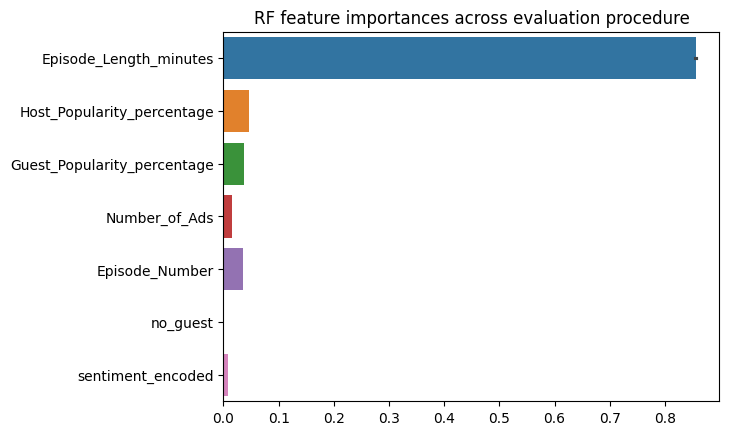

In [15]:
rf_importance(models_rf_abs, X_only_numeric.columns)

## Sobre target relativo

In [16]:
res_rf_rel, models_rf_rel = cv_model(
    lambda **kwargs: RandomForestRegressor(**kwargs), 
    X=X_only_numeric,
    is_rel=True,
    model_args=dict(n_jobs=-1)
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
res_rf_rel

,mae,mse,rmse
0,9.070510,134.188765,11.583987
1,8.890533,130.234522,11.412034
2,8.956191,132.021631,11.490067
3,8.989240,132.232704,11.499248
4,9.052935,133.802874,11.567319
mean,8.991882,132.496099,11.510531
std,0.073250,1.579715,0.068681


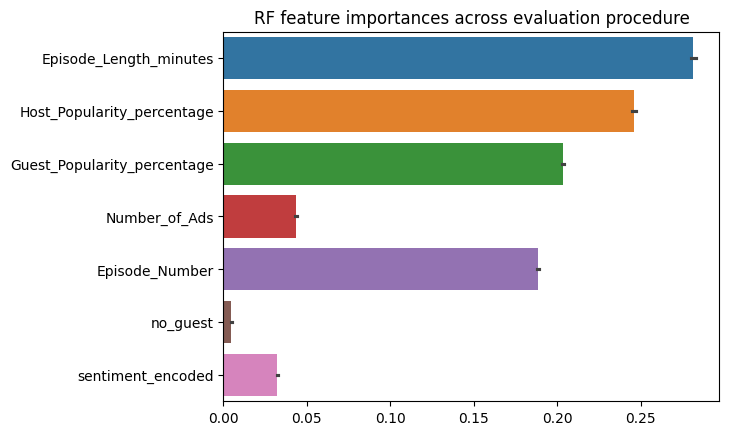

In [18]:
rf_importance(models_rf_rel, X_only_numeric.columns)

Se observa que la diferencia en performance entre usar target relativo y absoluto es mínima, aunque favorece levemente al target relativo.

Sin embargo, debe destacarse que el modelo con target relativo utiliza mucho mejor las diferentes features, mientras que el absoluto se concentra casi exclusivamente en la duración del podcast.

# Baseline + variables categóricas

## One Hot Encoding

In [19]:
res_onehot_rel, models_onehot_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',numeric_cols),
            (OneHotEncoder(sparse_output=False), cat_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
res_onehot_rel

,mae,mse,rmse
0,9.019913,131.514928,11.467996
1,8.838492,126.827743,11.261782
2,8.846835,128.197965,11.322454
3,8.864117,127.332418,11.284167
4,8.908441,128.511732,11.336302
mean,8.895560,128.476957,11.334540
std,0.074581,1.826075,0.080298


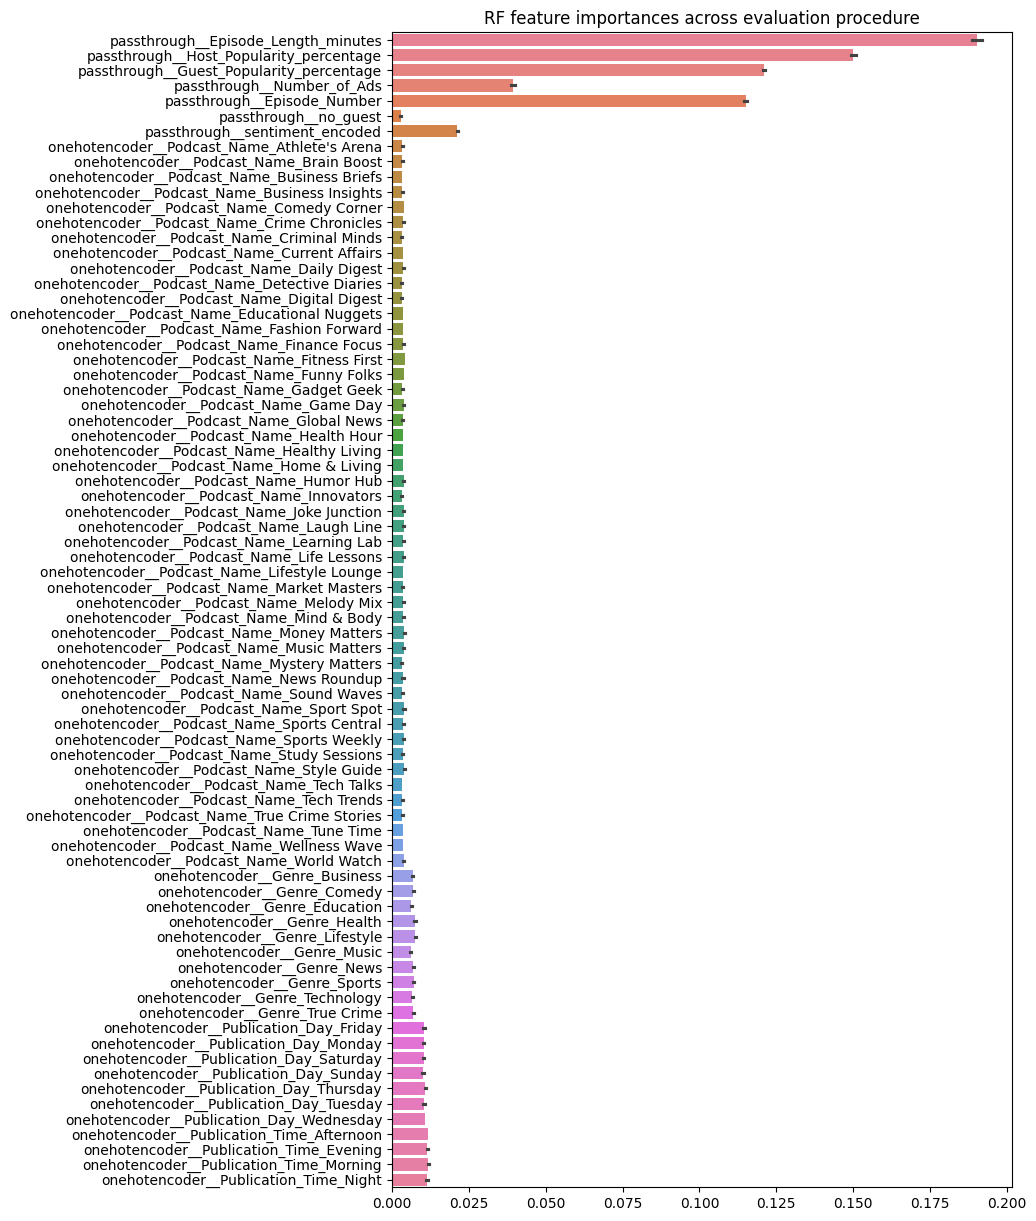

<Figure size 640x480 with 0 Axes>

In [21]:
fig, ax = plt.subplots(figsize=(8,15))
rf_importance(models_onehot_rel, models_onehot_rel[0][-2].get_feature_names_out())
plt.tight_layout()

## Target Encoding

In [22]:
res_tgt_rel, models_tgt_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',numeric_cols),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
res_tgt_rel

,mae,mse,rmse
0,8.965093,130.253494,11.412865
1,8.827420,126.882664,11.264221
2,8.831087,127.552471,11.293913
3,8.869788,126.896326,11.264827
4,8.919592,128.593844,11.339923
mean,8.882596,128.035760,11.315150
std,0.059237,1.422262,0.062728


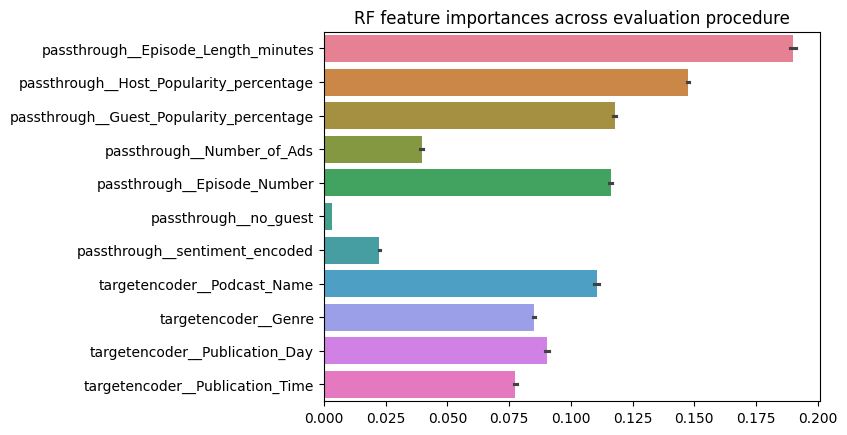

In [24]:
rf_importance(models_tgt_rel, models_tgt_rel[0][-2].get_feature_names_out())

Como se puede observar, la performance de las categorías encodeadas vía Target Encoding es superior a la de One Hot Encoding, incluso para aquellas de baja cardinalidad. Cabe destacar que el Target Encoder tiene hiperparámetros que no han sido tuneados, se están utilizando los default.

# Feature Engineering

In [53]:
# cantidad media de ads por minuto 
X['ad_density'] = X['Number_of_Ads'] / X['Episode_Length_minutes']

# popularidad sumada de Host y Guest
X['joint_popularity'] = X['Host_Popularity_percentage'] + X['Guest_Popularity_percentage']

# como son pocas categóricas, se pueden hacer combinaciones y luego encodearlas por algún tipo de target encoding
for n in range(2,len(cat_cols)+1):
    for cols in combinations(cat_cols,n):
        cols_list = list(cols) # pandas gets angry if they're tuples instead of lists
        X[f"comb_{n}_"+"+".join(cols)] = X[cols_list].apply(lambda s: '-'.join(s), axis=1)

In [ ]:
comb_cols = X.columns[X.columns.str.startswith('comb_')].tolist()

In [57]:
# a ver como se ve
X.head().T

,0,1,2,3,4
Podcast_Name,Healthy Living,Mystery Matters,Current Affairs,Mystery Matters,Money Matters
Episode_Length_minutes,99.25,19.43,117.03,16.97,28.06
Genre,Health,True Crime,News,True Crime,Business
Host_Popularity_percentage,21.37,47.19,96.33,25.73,22.02
Publication_Day,Thursday,Friday,Sunday,Monday,Wednesday
Publication_Time,Night,Evening,Night,Night,Morning
Guest_Popularity_percentage,70.22,75.15,57.95,24.19,-1.0
Number_of_Ads,3,1,3,0,1
Episode_Number,77,6,1,38,87
no_guest,False,False,False,False,True


Probamos su importancia utilizando un Random Forest con Target Encoding y valores default como antes.

In [63]:
res_fe_rel, models_fe_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',X.columns[X.dtypes != 'object']),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols+comb_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [64]:
res_fe_rel

,mae,mse,rmse
0,8.932290,128.396408,11.331214
1,8.768017,125.166865,11.187800
2,8.790201,125.687892,11.211061
3,8.827899,125.054409,11.182773
4,8.871487,126.724428,11.257195
mean,8.837979,126.206000,11.234008
std,0.065758,1.391137,0.061793


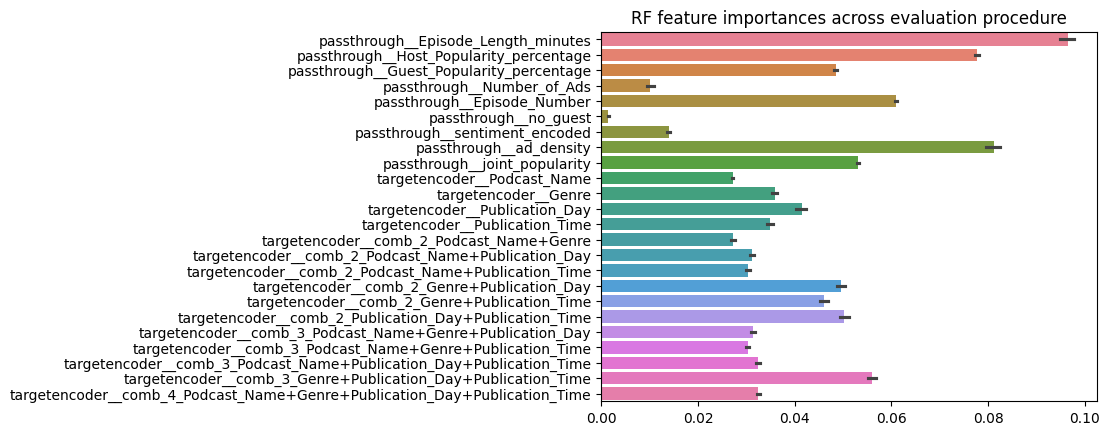

In [65]:
rf_importance(models_fe_rel, models_fe_rel[0][-2].get_feature_names_out())

Como se puede apreciar, con las nuevas variables el RMSE baja de 11.31 a 11.23 y el MAE de 8.88 a 8.83 (en media sobre 5 folds). Además la importancia de las variables es bastante alta y con poca variabilidad entre folds, lo que indica que tienen poder predictivo.

Por completitud se estima la performance utilizando target absoluto:

In [66]:
res_fe_abs, models_fe_abs = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',X.columns[X.dtypes != 'object']),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols+comb_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=False
)

res_fe_abs

  0%|          | 0/5 [00:00<?, ?it/s]

,mae,mse,rmse
0,8.930684,129.377880,11.374440
1,8.765511,124.732177,11.168356
2,8.859833,128.164768,11.320988
3,8.865215,127.117418,11.274636
4,8.906060,128.163360,11.320926
mean,8.865461,127.511121,11.291869
std,0.063095,1.747498,0.077561


Como era de esperarse, la performance es peor. Se confirma entonces qeu es mejor utilizar el target relativo.

# Testeo de diferentes modelos

**TO DO PROBAR DIFERENTES MODELOS CON VALORES DEFAULT**

* Ridge
* LASSO
* SVR
* LightGBM (probablemente el que mejor ande, probar usando su propio encoding en vez del Tgt Enc)

In [72]:
# ejemplo de LightGBM
from lightgbm import LGBMRegressor

X_cats = X.copy()

for col in cat_cols+comb_cols:
    X_cats[col] = X_cats[col].astype("category")

X_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40374 entries, 0 to 40373
Data columns (total 24 columns):
 #   Column                                                      Non-Null Count  Dtype   
---  ------                                                      --------------  -----   
 0   Podcast_Name                                                40374 non-null  category
 1   Episode_Length_minutes                                      40374 non-null  float64 
 2   Genre                                                       40374 non-null  category
 3   Host_Popularity_percentage                                  40374 non-null  float64 
 4   Publication_Day                                             40374 non-null  category
 5   Publication_Time                                            40374 non-null  category
 6   Guest_Popularity_percentage                                 40374 non-null  float64 
 7   Number_of_Ads                                               40374 non-null  

In [173]:
res_lgb_rel, models_lgb_rel = cv_model(
    lambda : LGBMRegressor(num_leaves=31, max_bin=2048, subsample=1., subsample_freq=8, colsample_bytree=0.9),
    X=X_cats,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14633
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 24
[LightGBM] [Info] Start training from score 0.713479
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14632
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 24
[LightGBM] [Info] Start training from score 0.713263
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14631
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 24
[LightGBM] [Info] Start 

In [174]:
res_lgb_rel

,mae,mse,rmse
0,9.137237,135.523631,11.641462
1,9.010697,132.784981,11.523237
2,9.001472,135.010756,11.619413
3,8.977305,132.087893,11.492950
4,9.067912,134.330331,11.590096
mean,9.038925,133.947519,11.573431
std,0.064230,1.463801,0.063279


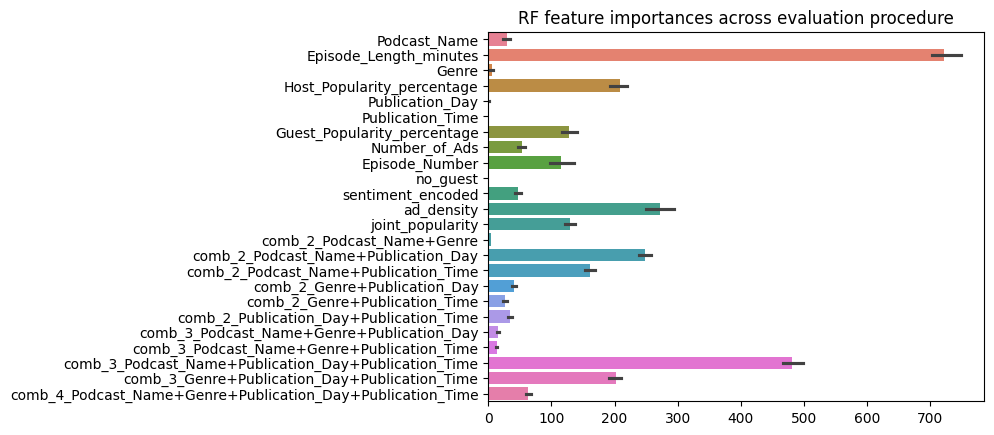

In [175]:
rf_importance(models_lgb_rel, X_cats.columns)

Parece que anda mal por insistencia en concentrarse en las mismas features, tal vez por eso anda mejor el RF? Ver los demás.


**TO DO HACER MINI FEATURE SELECTION Y HP TUNING SI ES POSIBLE CON OPTUNA Y W&B**

Nota martín: lo que yo creo que habría que hacer:

* Probar diferentes modelos con valores default sobre todas las variables
* Alguno de esos va a andar notablemente mejor que los demás (seguramente LightGBM)
* Agarrar el que sea preferible y hacer backward selection probando de dropear `Number_of_Ads`, `no_guest` y `sentiment_encoded` a ver si la performance mejora (recordar que estamos midiendo RMSE)
* Ahí hacer HP tuning con optuna y w&b

Recordar que LightGBM usa su propio target encoder, ver [ref](https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor) e [integr con optuna](https://optuna-integration.readthedocs.io/en/stable/reference/index.html#lightgbm).